AiAp - Mini project 1
# Lego CNN
Simon Hager
Kevin Löffler

In [343]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Step 1
## Import Data
Our dataset consists of 3D modeled lego bricks that are rendered as 400x400 greyscale png images. There are 50 different bricks and each brick is rendered in 800 angels giving us a total of 40'000 images. According to the project specification we reduced the dataset to 20 classes (bricks) resulting in 16'000 images.

### Classes
First we reduced the amount of bricks or classes from 50 to 5.

1. Brick Corner
2. Peg
3. Brick 2x4
4. Plate 1x2
5. Roof 2x3

Secondly we halved the images per class from 800 to 400. The script can be found in the GitHub repo (preprocessing.py)

### Size
Additionally, we rescaled all the remaining. With an automated batch process we halved the size of each image and converted them from png to jpg reducing the filesize to around 20% of the original image.

### Preprocessing Summary
We started with a dataset of 1gb with 50 classes and 40'000 images and reduced it to 5 classes and 2'000 images weighting 11mb.

### Performance
The preprocessing steps had a big impact on the training performance of the model. We started with an epoch time of 820 seconds per epoch. Reducing the dataset to 10 classes resulted in 209 seconds and reducing it again to 5 classes resulted in 92 seconds per training epoch. The rescaling and jpeg compression shaved another 41 and 13 seconds of the model respectively for a final epoch time of 38 seconds. All additional performance increases had to do with the model (eg: MaxPooling layers) and not with the input data.


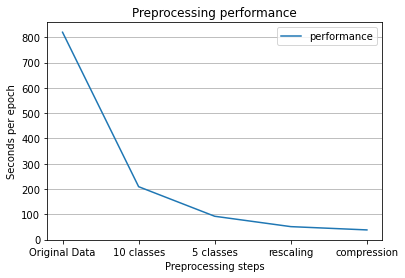

In [143]:
preprocessing_performance = [820, 209, 92, 51, 38]
preprocessing_performance_labels = ['Original Data', '10 classes', '5 classes', 'rescaling', 'compression']

plt.plot(preprocessing_performance)
plt.title('Preprocessing performance')
plt.xlabel('Preprocessing steps')
plt.xticks(range(len(preprocessing_performance)), preprocessing_performance_labels)
plt.ylabel('Seconds per epoch')
plt.legend(['performance'])
plt.grid(axis='y')
plt.show()

In [83]:
bricks = ['001 Corner', '002 Peg', '003 Brick', '004 Plate', '005 Roof']

We use a tensorflow dataset to import the data. The classes (bricks) are extracted from subdirectories in the data directory. The class names are inferred from the directory name. 20% of the data are kept for validation.

In [146]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'lego-bricks/dataset-v3',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (200, 200),
    shuffle = True,
    seed = 7,
    validation_split = 0.2,
    subset = 'training'
)

Found 2000 files belonging to 5 classes.
Using 1600 files for training.


In [147]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'lego-bricks/dataset-v3',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (200, 200),
    shuffle = True,
    seed = 7,
    validation_split = 0.2,
    subset = 'validation'
)

Found 2000 files belonging to 5 classes.
Using 400 files for validation.


To check if the data has been read in correctly we check its cardinality and plot 9 images from the training data.

In [152]:
testing_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=13>

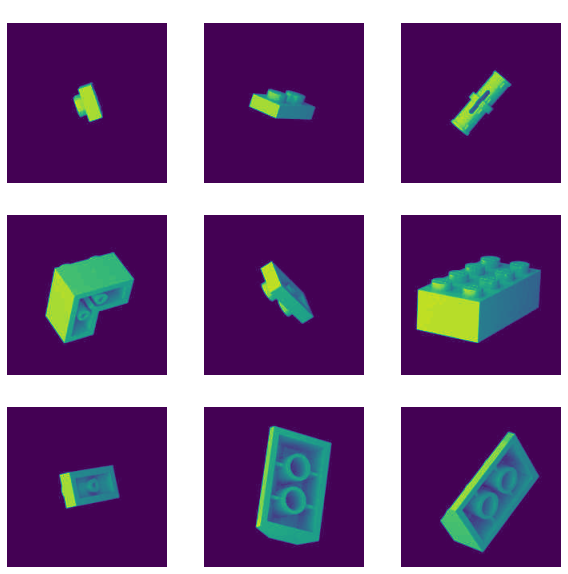

In [154]:
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(bricks[labels[i]], color='white')
        plt.axis('off')

Step 2
## Build the Model
To have a performant model the tensorflow docs suggest 2 performance optimization techniques:
- [Caching](https://www.tensorflow.org/guide/data_performance#caching) save some operations (like file opening and data reading) from being executed during each epoch. It caches the dataset in first epoch in memory or on local storage for further epochs.
- [Prefetching](https://www.tensorflow.org/guide/data_performance#prefetching) means the input pipeline is reading the data for step s+1 while the model is executing training step s. A side effect is the reduced memory usage.

We use the tensorflow autotune functionality to automatically find good buffer sizes.

In [88]:
AUTOTUNE = tf.data.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size = AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size = AUTOTUNE)

### Model
We tested several model architectures:
    - Models with one, two or three Conv2D layers
    - Layers with 2, 4, 8, 16, 32 and 64 neurons

We noticed that models with a higher neuron count started to overfit quickly. We got the optimal evaluation accuracy with a single layer network with 8 neurons.

The jumps in the plot below are explained by different amount of layers.

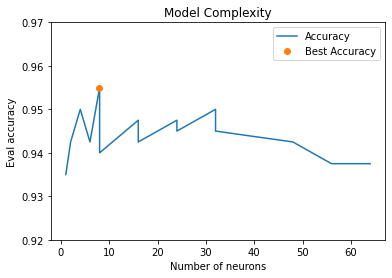

In [304]:
model_comparison = [
    # 1 layer models
    {'l1': 1, 'l2': 0, 'l3': 0, 'perf': .935},
    {'l1': 2, 'l2': 0, 'l3': 0, 'perf': .9425},
    {'l1': 4, 'l2': 0, 'l3': 0, 'perf': .95},
    {'l1': 8, 'l2': 0, 'l3': 0, 'perf': .955},
    {'l1': 16, 'l2': 0, 'l3': 0, 'perf': .9475},
    {'l1': 32, 'l2': 0, 'l3': 0, 'perf': .95},
    {'l1': 64, 'l2': 0, 'l3': 0, 'perf': .9375},
    # 2 layer models
    {'l1': 2, 'l2': 2, 'l3': 0, 'perf': .95},
    {'l1': 2, 'l2': 4, 'l3': 0, 'perf': .9425},
    {'l1': 4, 'l2': 4, 'l3': 0, 'perf': .94},
    {'l1': 8, 'l2': 8, 'l3': 0, 'perf': .9425},
    {'l1': 8, 'l2': 16, 'l3': 0, 'perf': .9475},
    {'l1': 16, 'l2': 8, 'l3': 0, 'perf': .945},
    {'l1': 16, 'l2': 16, 'l3': 0, 'perf': .945},
    {'l1': 16, 'l2': 32, 'l3': 0, 'perf': .9425},
    # 3 layer models
    {'l1': 8, 'l2': 16, 'l3': 32, 'perf': .9375},
]

sorted_performance = sorted(model_comparison, key = lambda x: x['l1'] + x['l2'] + x['l3'])

number_of_neurons = [a['l1'] + a['l2'] + a['l3'] for a in sorted_performance]
model_performance = [a['perf'] for a in sorted_performance]

plt.plot(number_of_neurons, model_performance)
plt.plot(7.9, .955, 'o')
plt.ylabel('Eval accuracy')
plt.xlabel('Number of neurons')
plt.yticks([.92, .93, .94, .95, .96, .97])
plt.title('Model Complexity')
plt.legend(['Accuracy', 'Best Accuracy'])
plt.show()

In [155]:
model = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape = (200, 200, 1)),
    layers.Conv2D(8, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # todo: test dropout with model
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(len(bricks))
])

### Learning rate
In addition to the model architecture we experimented with different learning rates.

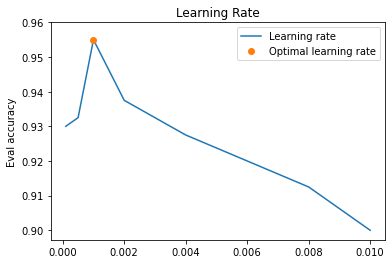

In [332]:
learning_rates = [.0001, .0005, .001, .002, .004, .008, .01]
learning_rate_perf = [.93, .9325, .955, .9375, .9275, .9125, .90]

plt.plot(learning_rates, learning_rate_perf)
plt.plot(.001, .955, 'o')
plt.ylabel('Eval accuracy')
plt.yticks([.9, .91, .92, .93, .94, .95, .96])
plt.title('Learning Rate')
plt.legend(['Learning rate', 'Optimal learning rate'])
plt.show()

## Dropout
We also experimented with different dropout values. Often the dropout layer did little to improve the performance of the model. But since it did not hinder performance we decided to let it in.

In [333]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [334]:
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

Step 3
## Train the Model

In [335]:
epochs = 20

In [337]:
history = model.fit(
    training_data,
    validation_data = testing_data,
    epochs = epochs
)

Epoch 1/20
50/50 [==============================] - 9s 177ms/step - loss: 0.2257 - accuracy: 0.9425 - val_loss: 0.3109 - val_accuracy: 0.8675
Epoch 2/20
50/50 [==============================] - 8s 154ms/step - loss: 0.1289 - accuracy: 0.9569 - val_loss: 0.1986 - val_accuracy: 0.9450
Epoch 3/20
50/50 [==============================] - 8s 153ms/step - loss: 0.0659 - accuracy: 0.9787 - val_loss: 0.2137 - val_accuracy: 0.9425
Epoch 4/20
50/50 [==============================] - 8s 159ms/step - loss: 0.0296 - accuracy: 0.9969 - val_loss: 0.1856 - val_accuracy: 0.9475
Epoch 5/20
50/50 [==============================] - 8s 155ms/step - loss: 0.0147 - accuracy: 0.9981 - val_loss: 0.1860 - val_accuracy: 0.9400
Epoch 6/20
50/50 [==============================] - 8s 154ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 0.9500
Epoch 7/20
50/50 [==============================] - 8s 157ms/step - loss: 0.0092 - accuracy: 0.9994 - val_loss: 0.2065 - val_accuracy: 0.9500
Epoch 

Visualize training results:

In [338]:
training_accuracy = history.history['accuracy']
training_val_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
training_val_loss = history.history['val_loss']

epochs_range = range(epochs)

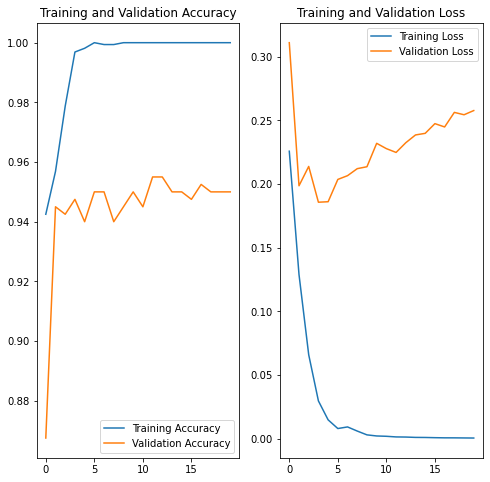

In [339]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, training_val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, training_val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

Step 4
# Evaluate

With the following confusion matrices, we can evaluate, how well the model performs on random datae

In [340]:
y_pred = []  # store the predicted labels
y_true = []  # store the true labels

# iterate over the dataset
# x = image
# y = label
for x, y in testing_data:
    y_true.append(y)
    predictions = model.predict(x)
    y_pred.append(tf.argmax(predictions, axis=-1)) # 1 or -1

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

true_positives = [0] * len(bricks)
false_positives = [0] * len(bricks)
true_negatives = [0] * len(bricks)
false_negatives = [0] * len(bricks)

for x, y in zip(correct_labels, predicted_labels):
    if tf.math.equal(tf.cast(x, tf.int64), y):
        true_positives[x]+=1
        for z in false_positives:
            if not z == x:
                true_negatives[x]+=1
    else:
        false_positives[x]+=1
        false_negatives[y]+=1

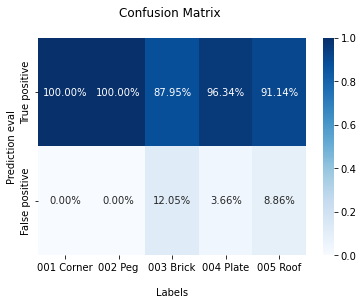

In [344]:
total_pos = np.sum(list(map(list, zip(true_positives, false_positives))), axis=1)

ax = sns.heatmap([true_positives/total_pos, false_positives/total_pos], annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix \n')
ax.set_xlabel('\nLabels')
ax.set_ylabel('Prediction eval')

ax.xaxis.set_ticklabels(bricks)
ax.yaxis.set_ticklabels(['True positive','False positive'])

plt.show()

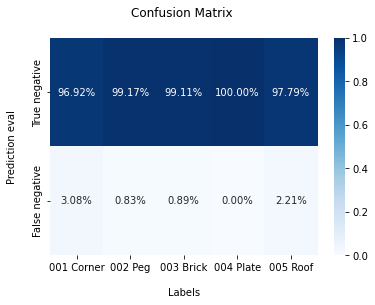

In [345]:
total_neg = np.sum(list(map(list, zip(true_negatives, false_negatives))), axis=1)

ax = sns.heatmap([true_negatives/total_neg, false_negatives/total_neg], annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix \n')
ax.set_xlabel('\nLabels')
ax.set_ylabel('Prediction eval\n')

ax.xaxis.set_ticklabels(bricks)
ax.yaxis.set_ticklabels(['True negative','False negative'])

plt.show()

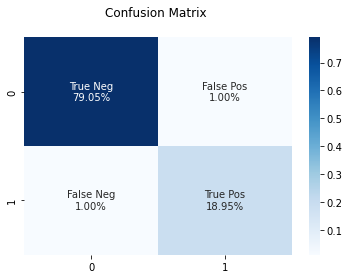

In [346]:
total_neg = np.sum(list(map(list, zip(true_negatives, false_negatives))), axis=1)

true_negatives_total = np.sum(true_negatives)
false_positives_total = np.sum(false_positives)
false_negatives_total = np.sum(false_negatives)
true_positives_total = np.sum(true_positives)

total = np.sum([true_negatives_total, false_positives_total, false_negatives_total, true_positives_total])

cf_matrix = np.array([[true_negatives_total/total, false_positives_total/total], [false_negatives_total/total, true_positives_total/total]])

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flat]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix \n')

plt.show()